# Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, train_test_split, cross_val_score, KFold)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
# import warnings filter
from warnings import simplefilter, filterwarnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
filterwarnings("error", message=".*check_inverse*.", category=UserWarning, append=False)

In [3]:
df_identity = pd.read_csv('train_identity.csv')
df_transaction = pd.read_csv('train_transaction.csv')

In [4]:
df_identity.select_dtypes(include=object).head()

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,NotFound,New,NotFound,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,NotFound,New,NotFound,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,NotFound,Found,Found,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,Windows
3,NotFound,New,NotFound,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,NaN
4,NotFound,Found,Found,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
df_transaction.select_dtypes(include=object).head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# The unique values for the below mentioned columns are 'Found', 'NotFound' or 'New'.
# Hence, updating the string values 'New', 'Found' and 'NotFound' to
# '2', '1' and '0' respectively.
mapValues1 = {'New': 2, 'Found': 1, 'NotFound': 0}
df_identity['id_12'] = df_identity['id_12'].map(mapValues1)
df_identity['id_15'] = df_identity['id_15'].map(mapValues1)
df_identity['id_16'] = df_identity['id_16'].map(mapValues1)
df_identity['id_27'] = df_identity['id_27'].map(mapValues1)
df_identity['id_28'] = df_identity['id_28'].map(mapValues1)
df_identity['id_29'] = df_identity['id_29'].map(mapValues1)

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
mapValues2 = {'T': 1, 'F': 0}
df_identity['id_35'] = df_identity['id_35'].map(mapValues2)
df_identity['id_36'] = df_identity['id_36'].map(mapValues2)
df_identity['id_37'] = df_identity['id_37'].map(mapValues2)
df_identity['id_38'] = df_identity['id_38'].map(mapValues2)

# Since, most of the columns have values as 'NaN' where 'id_35' is equal to 'NaN', hence
# removing those rows from the dataset. This removes only 2.25% of total data
#df1 = df1[df1['id_35'].notnull()]

# Replacing the NaN values of 'DeviceType' column with 'desktop' because as per analysis
# for the mentioned 'DeviceInfo' and its combination with column 'id_31', the device type is equal to 'desktop'
df_identity['DeviceType'].loc[df_identity['DeviceInfo'].isin(['Windows','rv:11.0','Trident/7.0'])] = 'desktop'

####################################################################################

# Adding new column TransactionDay by calculating the value from TransactionDT column
# math.ceil returns smallest integer greater than the provided value.
df_transaction['TransactionDay']=np.ceil(df_transaction['TransactionDT']/60/60/24).astype('int')

# Replacing NaN values of card4 based on common card1 values
df_transaction.loc[df_transaction.card4.isnull(), 'card4'] = \
df_transaction.loc[df_transaction.card4.isnull(), 'card1'].map(df_transaction[df_transaction.card4.notnull()] \
                    [['card1','card4']].sort_values('card1').drop_duplicates().set_index('card1')['card4'])

#Replace few card6 values to valid specific values
df_transaction.card6 = df_transaction.card6.replace(to_replace=['debit or credit'], value=['debit'])
df_transaction.card6 = df_transaction.card6.replace(to_replace=['charge card'], value=['credit'])

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
df_transaction['M1'] = df_transaction['M1'].map(mapValues2)
df_transaction['M2'] = df_transaction['M2'].map(mapValues2)
df_transaction['M3'] = df_transaction['M3'].map(mapValues2)
df_transaction['M5'] = df_transaction['M5'].map(mapValues2)
df_transaction['M6'] = df_transaction['M6'].map(mapValues2)
df_transaction['M7'] = df_transaction['M7'].map(mapValues2)
df_transaction['M8'] = df_transaction['M8'].map(mapValues2)
df_transaction['M9'] = df_transaction['M9'].map(mapValues2)


# label encoding the data
le = LabelEncoder() 
df_identity['DeviceType']= le.fit_transform(df_identity['DeviceType'].astype(str)) 
df_identity['id_23']= le.fit_transform(df_identity['id_23'].astype(str)) 
df_transaction['card4']= le.fit_transform(df_transaction['card4'].astype(str)) 
df_transaction['card6']= le.fit_transform(df_transaction['card6'].astype(str)) 
df_transaction['ProductCD']= le.fit_transform(df_transaction['ProductCD'].astype(str)) 

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# Creating main dataset by merging both the DataFrames created from two csv files
dataset = pd.merge(df_transaction,df_identity,on='TransactionID',how='left')

In [8]:
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID to DeviceInfo
dtypes: float64(419), int64(8), object(8)
memory usage: 1.9+ GB


In [9]:
dataset.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,1.0,0.0,1.0,1.0,1.0,SAMSUNG SM-G892A Build/NRD90M


In [10]:
dataset[dataset.select_dtypes(["object"]).columns] = dataset.select_dtypes(["object"]).apply(
    lambda x: x.astype("category")
)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID to DeviceInfo
dtypes: category(8), float64(419), int64(8)
memory usage: 1.9 GB


In [11]:
def coeff_of_determination(X,Y):
    # Model Intialization
    reg = LogisticRegression()
    # Data Fitting
    reg = reg.fit(X, Y)

    # Model Evaluation
    r2 = reg.score(X, Y)
    return r2

In [12]:
X = np.array([dataset.card1, dataset.C1, dataset.TransactionDay]).T
Y = np.array(dataset.isFraud)
coeff_of_determination(X,Y)

0.9650099908558268

__Using Imputer for mapping NaN values with respective median values.__

In [22]:
Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude='category')
y = dataset.isFraud
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

Text(0, 0.5, 'explained_variance_')

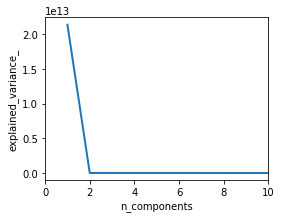

In [14]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(solver='liblinear')
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
# Plot the PCA spectrum
pca.fit(X)
plt.figure(1, figsize=(4, 3))
plt.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_, linewidth=2)
plt.xlim([0,10])
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [15]:
param_grid = {
    'pca__n_components': [2, 5, 10, 15]
}
search = GridSearchCV(pipe, param_grid)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Convergenc

Best parameter (CV score=0.965):
{'pca__n_components': 2}


In [24]:
def modelPrediction(modelObj, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = False, isOverSample = False, isUnderSample = False, nfold = 1):
    train_accuracy = []
    test_accuracy = []
    conf_matrices = []
    #Receiver Operating Characteristic Area Under Curve score
    rocaucscore = []
    
    X_train = Xtrain.values
    X_test = Xtest.values
    y_train = ytrain.values
    y_test = ytest.values
    
    if isOverSample:
        print("Performing SMOTE over-sampling")
        sampleObj = SMOTE()
    elif isUnderSample:
        print("Performing NearMiss under-sampling")
        sampleObj = NearMiss()

    if isPCA:
        if (isOverSample or isUnderSample):
            print("Model with PCA and with sampling")
            pipeline = make_pipeline_imb(SimpleImputer(missing_values = np.nan, strategy = 'median'),
                                         PCA(n_components = 2), sampleObj , modelObj)
        else:
            print("Model with PCA and without sampling")
            pipeline = Pipeline(steps=[('imputation',imputer),('pca', PCA(n_components = 2)),('Model', modelObj)])       
    else:
        if (isOverSample or isUnderSample):
            print("Model without PCA and with sampling")
            pipeline = make_pipeline_imb(SimpleImputer(missing_values = np.nan, strategy = 'median'),
                                         sampleObj , modelObj)
        else:
            print("Model without PCA and without sampling")
            pipeline = Pipeline(steps=[('imputation',imputer),('Model', modelObj)])       
    
    if(nfold > 1):
        for train, test in KFold(nfold).split(X_train):
        
            model = pipeline.fit(X_train[train], y_train[train])
            model_predictions = model.predict(X_train[test])
    
            #scoring metrics
            train_accuracy.append(accuracy_score(y_train[train], model.predict(X_train[train])))
            test_accuracy.append(accuracy_score(y_train[test], model_predictions))
            rocaucscore.append(roc_auc_score(y_train[test], model_predictions))
    
            #confusion matrices
            conf_matrices.append(confusion_matrix(y_train[test], model_predictions))
    else:
        model = pipeline.fit(X_train, y_train)
        model_predictions = model.predict(X_test)
    
        #scoring metrics
        train_accuracy.append(accuracy_score(y_train, model.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, model_predictions))
        rocaucscore.append(roc_auc_score(y_test, model_predictions))
    
        #confusion matrices
        conf_matrices.append(confusion_matrix(y_test, model_predictions))
        
    #Print the score metrics
    print('Train accuracy: {}'.format(np.mean(train_accuracy)))
    print('Validation accuracy: {}'.format(np.mean(test_accuracy)))
    print('Test accuracy: {}'.format(accuracy_score(y_test, model.predict(X_test))))
    print('ROC AUC score: {}'.format(np.mean(rocaucscore)))    
    
    # Plot ROC curve
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    _ = plt.plot([0, 1], [0, 1], 'k--')
    _ = plt.plot(fpr, tpr)
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('ROC Curve')
    
    target_labels = ['non_fraud', 'fraud']
    print("The classification report is :")
    print(classification_report(y_test, model.predict(X_test), target_names=target_labels))
        
    #fig, ax = plt.subplots(figsize=(20, 3), nrows=1, ncols=nfold)
    #k = 0
    print('Confusion Matrices')
    print('.'*60)
    for conf_matrix in conf_matrices:
        print(conf_matrix)
        print('.'*15)
        #if(nfold > 1):
        #    sns.heatmap(conf_matrix, cbar=False, xticklabels=target_labels, \
        #            yticklabels=target_labels, ax=ax[0][k], annot=True, annot_kws={'size' : 15})
        #else:
        #    sns.heatmap(conf_matrix, cbar=False, xticklabels=target_labels, \
        #            yticklabels=target_labels, annot=True, annot_kws={'size' : 15})
        #ax1.set_ylabel('Actual Labels')
        #ax1.set_xlabel('Predicted Labels')
        #k= k + 1
    return model

### 1) Applying Logistic Regression

__From below details of the model we can see that the `recall` value is 0 which indicates that the model does not do well in identifying the relevant instance of classification model and in this case which is identifying the fraud transactions.__

Model without PCA and without sampling
Train accuracy: 0.9649618508967579
Validation accuracy: 0.9649416917849201
Test accuracy: 0.9649416917849201
ROC AUC score: 0.5002758389319961
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.97      1.00      0.98    170963
       fraud       0.20      0.00      0.00      6199

    accuracy                           0.96    177162
   macro avg       0.58      0.50      0.49    177162
weighted avg       0.94      0.96      0.95    177162

Confusion Matrices
............................................................
[[170947     16]
 [  6195      4]]
...............


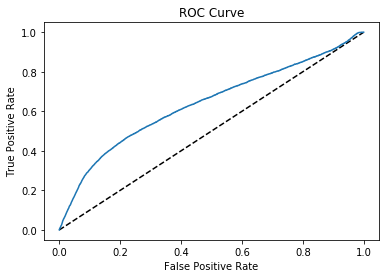

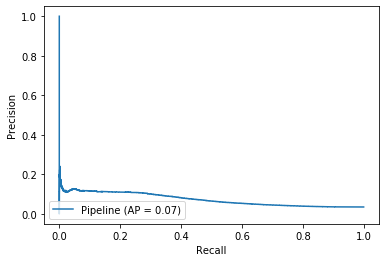

In [25]:
lg = LogisticRegression(solver='liblinear', random_state=21)
lgmodel = modelPrediction(lg, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = False, isOverSample = False, isUnderSample = False)
_ = plot_precision_recall_curve(lgmodel, Xtestlr, ytestlr)

### 2) Applying Logistic Regression with PCA (Principal Component Analysis)

Model with PCA and without sampling
Train accuracy: 0.965010232765169
Validation accuracy: 0.9650094264006954
Test accuracy: 0.9650094264006954
ROC AUC score: 0.5
The classification report is :


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   non_fraud       0.97      1.00      0.98    170963
       fraud       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162

Confusion Matrices
............................................................
[[170963      0]
 [  6199      0]]
...............


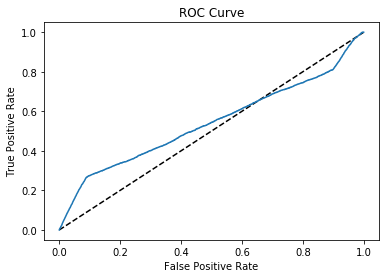

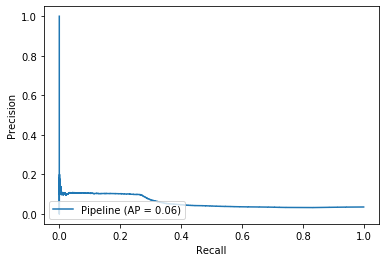

In [28]:
lgPCA = LogisticRegression(solver='liblinear', random_state=21)
lgPCAModel = modelPrediction(lgPCA, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = False, isUnderSample = False)
_ = plot_precision_recall_curve(lgPCAModel, Xtestlr, ytestlr)

### 3) Applying Logistic Regression and Under Sampling (NearMiss) during Cross Validation

Performing NearMiss under-sampling
Model without PCA and with sampling
Train accuracy: 0.7336632582012406
Validation accuracy: 0.7337303892974735
Test accuracy: 0.7344577279552048
ROC AUC score: 0.720473905319057
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.99      0.74      0.84    170963
       fraud       0.09      0.70      0.16      6199

    accuracy                           0.73    177162
   macro avg       0.54      0.72      0.50    177162
weighted avg       0.95      0.73      0.82    177162

Confusion Matrices
............................................................
[[57884 21873]
 [  788  2131]]
...............
[[58074 21704]
 [  851  2047]]
...............
[[59833 19957]
 [  941  1945]]
...............
[[58284 21539]
 [  800  2052]]
...............
[[59018 20748]
 [  869  2040]]
...............


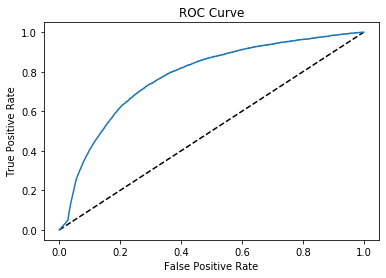

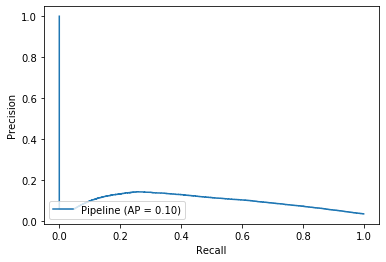

In [29]:
lgUnder = LogisticRegression(solver='liblinear', random_state = 21)
lgUnderModel = modelPrediction(lgUnder, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = False, isOverSample = False, isUnderSample = True, nfold = 5)
_ = plot_precision_recall_curve(lgUnderModel, Xtestlr, ytestlr)

### 4) Applying Logistic Regression and Over Sampling (SMOTE: Synthetic Minority Oversampling Technique) during Cross Validation

Performing SMOTE over-sampling
Model with PCA and with sampling
Train accuracy: 0.6396458009253554
Validation accuracy: 0.6398405270431647
Test accuracy: 0.6354184305889525
ROC AUC score: 0.5421856067388169
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.97      0.64      0.77    170963
       fraud       0.04      0.44      0.08      6199

    accuracy                           0.64    177162
   macro avg       0.51      0.54      0.43    177162
weighted avg       0.94      0.64      0.75    177162

Confusion Matrices
............................................................
[[87113 45852]
 [ 2735  2093]]
...............
[[85352 47651]
 [ 2657  2133]]
...............
[[85708 47238]
 [ 2749  2097]]
...............


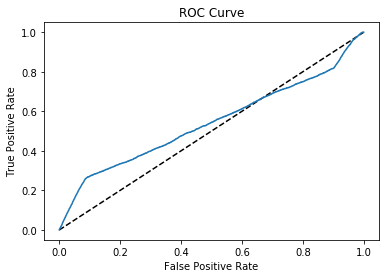

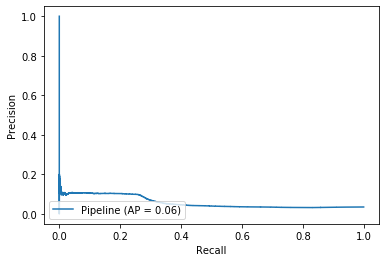

In [30]:
lgOver = LogisticRegression(solver='liblinear', random_state=21)
lgOverModel = modelPrediction(lgOver, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = True, isUnderSample = False, nfold = 3)
_ = plot_precision_recall_curve(lgOverModel, Xtestlr, ytestlr)

### 5) Applying DecisionTreeClassifier with PCA

Model with PCA and without sampling
Train accuracy: 1.0
Validation accuracy: 0.9406136756189251
Test accuracy: 0.9406136756189251
ROC AUC score: 0.5657930013991881
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.97      0.97      0.97    170963
       fraud       0.16      0.16      0.16      6199

    accuracy                           0.94    177162
   macro avg       0.56      0.57      0.57    177162
weighted avg       0.94      0.94      0.94    177162

Confusion Matrices
............................................................
[[165632   5331]
 [  5190   1009]]
...............


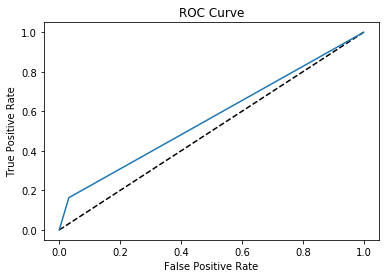

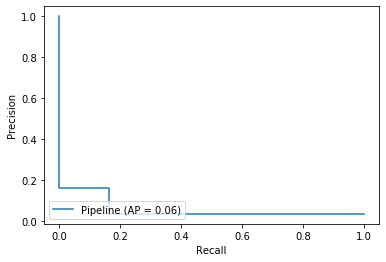

In [31]:
dtPCA = DecisionTreeClassifier(random_state=21)
dtPCAModel = modelPrediction(dtPCA, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = False, isUnderSample = False, nfold = 0)
_ = plot_precision_recall_curve(dtPCAModel, Xtestlr, ytestlr)

### 6) Applying DecisionTreeClassifier and Under Sampling during Cross Validation

Performing NearMiss under-sampling
Model with PCA and with sampling
Train accuracy: 0.1922272136684967
Validation accuracy: 0.1840180094964648
Test accuracy: 0.1812126754044321
ROC AUC score: 0.5333355894273052
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.98      0.15      0.27    170963
       fraud       0.04      0.92      0.07      6199

    accuracy                           0.18    177162
   macro avg       0.51      0.54      0.17    177162
weighted avg       0.95      0.18      0.26    177162

Confusion Matrices
............................................................
[[12823 66934]
 [  285  2634]]
...............
[[12565 67213]
 [  252  2646]]
...............
[[12625 67165]
 [  267  2619]]
...............
[[12368 67455]
 [  270  2582]]
...............
[[12541 67225]
 [  243  2666]]
...............


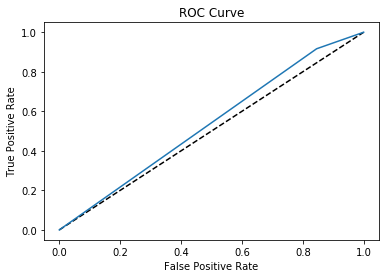

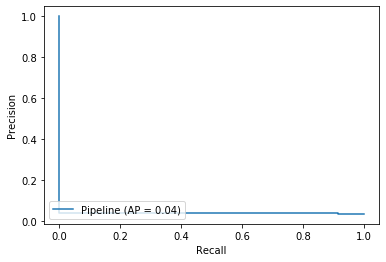

In [32]:
dtUnder = DecisionTreeClassifier(random_state=21)
dtUnderModel = modelPrediction(dtUnder, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = False, isUnderSample = True, nfold = 5)
_ = plot_precision_recall_curve(dtUnderModel, Xtestlr, ytestlr)

### 7) Applying DecisionTreeClassifier and Over Sampling during Cross Validation

Performing SMOTE over-sampling
Model with PCA and with sampling
Train accuracy: 1.0
Validation accuracy: 0.8075877314402903
Test accuracy: 0.8088529142818437
ROC AUC score: 0.6004347841415323
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.97      0.82      0.89    170963
       fraud       0.07      0.38      0.12      6199

    accuracy                           0.81    177162
   macro avg       0.52      0.60      0.51    177162
weighted avg       0.94      0.81      0.87    177162

Confusion Matrices
............................................................
[[109390  23575]
 [  2958   1870]]
...............
[[109336  23667]
 [  2998   1792]]
...............
[[109650  23296]
 [  3045   1801]]
...............


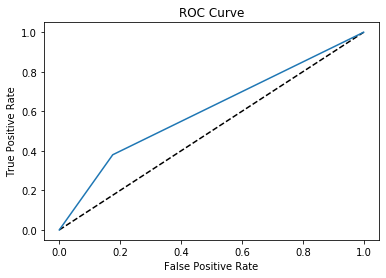

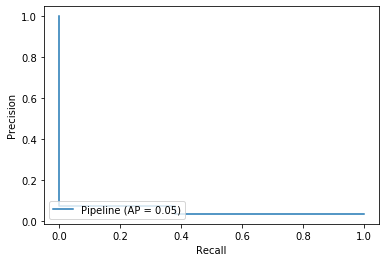

In [33]:
dtOver = DecisionTreeClassifier(random_state=21)
dtOverModel = modelPrediction(dtOver, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = True, isUnderSample = False, nfold = 3)
_ = plot_precision_recall_curve(dtOverModel, Xtestlr, ytestlr)

### 8) Applying RandomForestClassifier with PCA

Model with PCA and without sampling
Train accuracy: 0.9999443608513273
Validation accuracy: 0.9636321558799291
Test accuracy: 0.9636321558799291
ROC AUC score: 0.5178647164416795
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.97      1.00      0.98    170963
       fraud       0.33      0.04      0.07      6199

    accuracy                           0.96    177162
   macro avg       0.65      0.52      0.53    177162
weighted avg       0.94      0.96      0.95    177162

Confusion Matrices
............................................................
[[170480    483]
 [  5960    239]]
...............


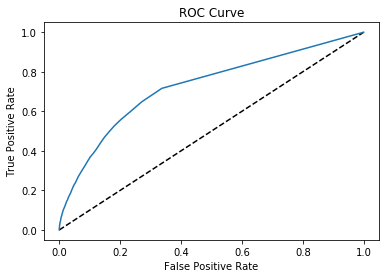

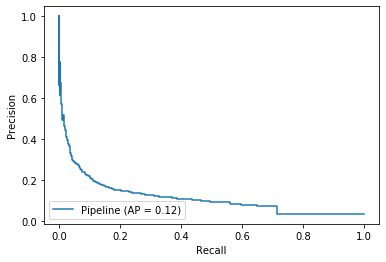

In [34]:
rfPCA = RandomForestClassifier(random_state=21)
rfPCAModel = modelPrediction(rfPCA, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = False, isUnderSample = False, nfold = 0)
_ = plot_precision_recall_curve(rfPCAModel, Xtestlr, ytestlr)

### 9) Applying RandomForestClassifier and Under Sampling during Cross Validation

Performing NearMiss under-sampling
Model without PCA and with sampling
Train accuracy: 0.6912420353719732
Validation accuracy: 0.6834446998870545
Test accuracy: 0.6814328129057021
ROC AUC score: 0.7523203599013344
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.99      0.68      0.80    170963
       fraud       0.09      0.83      0.15      6199

    accuracy                           0.68    177162
   macro avg       0.54      0.75      0.48    177162
weighted avg       0.96      0.68      0.78    177162

Confusion Matrices
............................................................
[[54344 25413]
 [  479  2440]]
...............
[[53678 26100]
 [  480  2418]]
...............
[[54029 25761]
 [  542  2344]]
...............
[[54324 25499]
 [  491  2361]]
...............
[[54193 25573]
 [  519  2390]]
...............


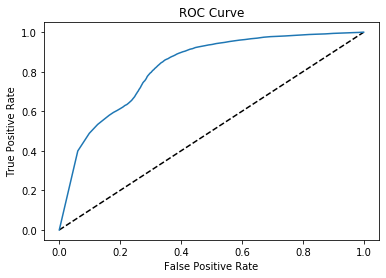

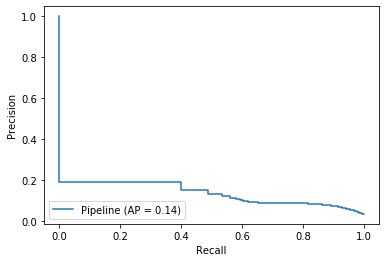

In [35]:
rfUnder = RandomForestClassifier(random_state=21)
rfUnderModel = modelPrediction(rfUnder, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = False, isOverSample = False, isUnderSample = True, nfold = 5)
_ = plot_precision_recall_curve(rfUnderModel, Xtestlr, ytestlr)

### 10) Applying RandomForestClassifier with PCA and Under Sampling during Cross Validation

Performing NearMiss under-sampling
Model with PCA and with sampling
Train accuracy: 0.2153005262049915
Validation accuracy: 0.20949590433445459
Test accuracy: 0.2045303168851108
ROC AUC score: 0.5403461722307397
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.98      0.18      0.30    170963
       fraud       0.04      0.90      0.07      6199

    accuracy                           0.20    177162
   macro avg       0.51      0.54      0.19    177162
weighted avg       0.95      0.20      0.30    177162

Confusion Matrices
............................................................
[[14831 64926]
 [  335  2584]]
...............
[[14781 64997]
 [  278  2620]]
...............
[[14746 65044]
 [  317  2569]]
...............
[[14905 64918]
 [  296  2556]]
...............
[[14377 65389]
 [  277  2632]]
...............


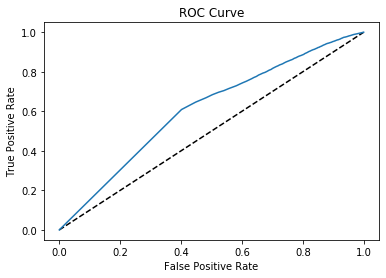

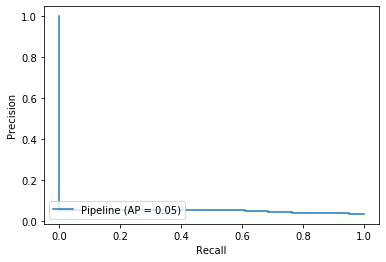

In [37]:
rfPCAUnder = RandomForestClassifier(random_state=21)
rfPCAUnderModel = modelPrediction(rfPCAUnder, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = False, isUnderSample = True, nfold = 5)
_ = plot_precision_recall_curve(rfPCAUnderModel, Xtestlr, ytestlr)

### 11) Applying RandomForestClassifier and Over Sampling during Cross Validation

Performing SMOTE over-sampling
Model without PCA and with sampling
Train accuracy: 0.9999903236233919
Validation accuracy: 0.9777927218899674
Test accuracy: 0.9778846479493345
ROC AUC score: 0.7070072780194409
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.98      1.00      0.99    170963
       fraud       0.89      0.42      0.57      6199

    accuracy                           0.98    177162
   macro avg       0.94      0.71      0.78    177162
weighted avg       0.98      0.98      0.97    177162

Confusion Matrices
............................................................
[[132741    224]
 [  2774   2054]]
...............
[[132739    264]
 [  2829   1961]]
...............
[[132703    243]
 [  2846   2000]]
...............


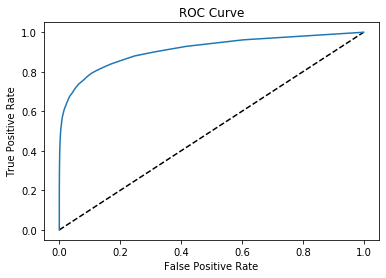

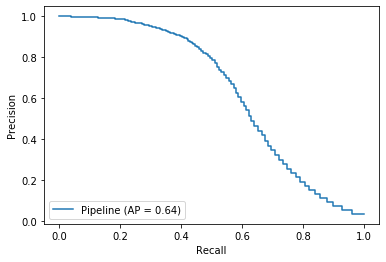

In [27]:
rfOver = RandomForestClassifier(random_state = 21)
rfOverModel = modelPrediction(rfOver, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = False, isOverSample = True, isUnderSample = False, nfold = 3)
_ = plot_precision_recall_curve(rfOverModel, Xtestlr, ytestlr)

### 12) Applying RandomForestClassifier with PCA and Over Sampling during Cross Validation

Performing SMOTE over-sampling
Model with PCA and with sampling
Train accuracy: 0.9999770186154308
Validation accuracy: 0.8134346827366429
Test accuracy: 0.8150336979713483
ROC AUC score: 0.6308174309343565
The classification report is :
              precision    recall  f1-score   support

   non_fraud       0.98      0.83      0.90    170963
       fraud       0.09      0.44      0.14      6199

    accuracy                           0.82    177162
   macro avg       0.53      0.64      0.52    177162
weighted avg       0.94      0.82      0.87    177162

Confusion Matrices
............................................................
[[109795  23170]
 [  2708   2120]]
...............
[[109867  23136]
 [  2715   2075]]
...............
[[110310  22636]
 [  2757   2089]]
...............


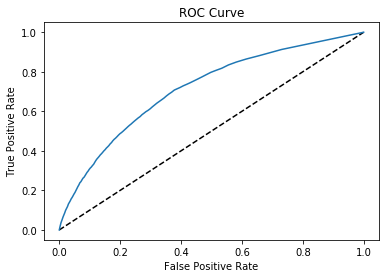

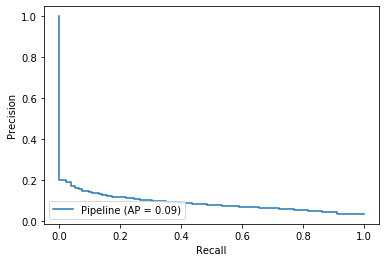

In [38]:
rfPCAOver = RandomForestClassifier(random_state = 21)
rfPCAOverModel = modelPrediction(rfPCAOver, Xtrain=Xlr, Xtest=Xtestlr, ytrain=ylr, ytest=ytestlr,
                    isPCA = True, isOverSample = True, isUnderSample = False, nfold = 3)
_ = plot_precision_recall_curve(rfPCAOverModel, Xtestlr, ytestlr)

### 13) Applying over sampling (SMOTE) after splitting

Before resampling, counts of frauds '1': 20663
Before resampling, counts of non-frauds '0': 569877 

After OverSampling, the shape of train_X: (797828, 426)
After OverSampling, the shape of train_y: (797828,) 

After OverSampling, counts of frauds '1': 398914
After OverSampling, counts of non-frauds '0': 398914


//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train accuracy: 0.6759389241791464
Test accuracy: 0.6553832085887493
The confusion matrix is :
[[111812  59151]
 [  1902   4297]]
The classification report is :
              precision    recall  f1-score   support

           0       0.98      0.65      0.79    170963
           1       0.07      0.69      0.12      6199

    accuracy                           0.66    177162
   macro avg       0.53      0.67      0.45    177162
weighted avg       0.95      0.66      0.76    177162

The roc_auc_score is : 0.7487818114812206


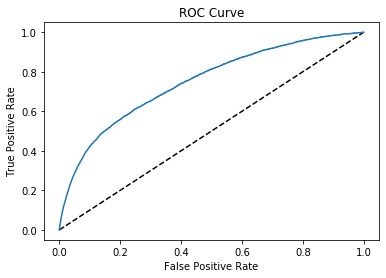

In [29]:
print("Before resampling, counts of frauds '1': {}".format(sum(y == 1))) 
print("Before resampling, counts of non-frauds '0': {} \n".format(sum(y == 0))) 

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=5,test_size=0.3, stratify = y)
sm = SMOTE(random_state = 2) 

Xtrain_overres, ytrain_overres = sm.fit_sample(Xtrain, ytrain) 
  
print('After OverSampling, the shape of train_X: {}'.format(Xtrain_overres.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(ytrain_overres.shape)) 
  
print("After OverSampling, counts of frauds '1': {}".format(sum(ytrain_overres == 1))) 
print("After OverSampling, counts of non-frauds '0': {}".format(sum(ytrain_overres == 0)))

clf = LogisticRegression(solver='liblinear')
clf.fit(Xtrain_overres, ytrain_overres)
y_res_pred = clf.predict(Xtest)
y_pred_prob = clf.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(clf.predict(Xtrain_overres), ytrain_overres)))
print("Test accuracy: {}".format(accuracy_score(y_res_pred, ytest)))
print("The confusion matrix is :")
print(confusion_matrix(ytest, y_res_pred))
print("The classification report is :")
print(classification_report(ytest, y_res_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytest, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### 14) Applying XGBoost

__XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.__

Train accuracy: 0.9409813778188486
Test accuracy: 0.9337781239769251
The confusion matrix is :
[[160343  10620]
 [  1112   5087]]
The classification report is :
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    170963
           1       0.32      0.82      0.46      6199

    accuracy                           0.93    177162
   macro avg       0.66      0.88      0.71    177162
weighted avg       0.97      0.93      0.95    177162

The roc_auc_score is : 0.9532476712860016


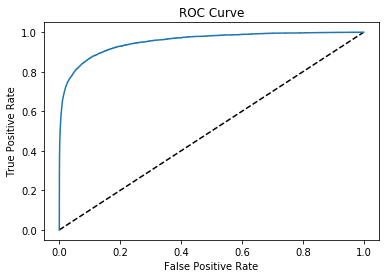

In [19]:
from xgboost import XGBClassifier
from xgboost import plot_importance

Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude='category')
y = dataset.isFraud
XG_train, XG_test, yg_train, yg_test = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

#scale_pos_weight [default=1] : Control the balance of positive and negative weights, 
#useful for unbalanced classes. 
#A typical value to consider: sum(negative instances) / sum(positive instances).
ratio = float(np.sum(y == 0)) / np.sum(y==1)

XGModel = XGBClassifier(scale_pos_weight = ratio, learning_rate =0.1, n_estimators=363, max_depth=6, 
                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4, seed=27)

XGModel.fit(XG_train,yg_train)

y_XG_pred = XGModel.predict(XG_test)

features = XGModel.feature_importances_
yg_pred_prob = XGModel.predict_proba(XG_test)[:,1]
fpr, tpr, threshold = roc_curve(yg_test, yg_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(XGModel.predict(XG_train), yg_train)))
print("Test accuracy: {}".format(accuracy_score(y_XG_pred, yg_test)))
print("The confusion matrix is :")
print(confusion_matrix(yg_test, y_XG_pred))
print("The classification report is :")
print(classification_report(yg_test, y_XG_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(yg_test, yg_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

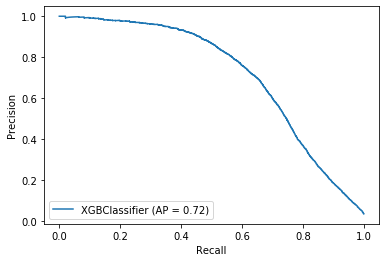

In [36]:
_ = plot_precision_recall_curve(XGModel, XG_test, yg_test)

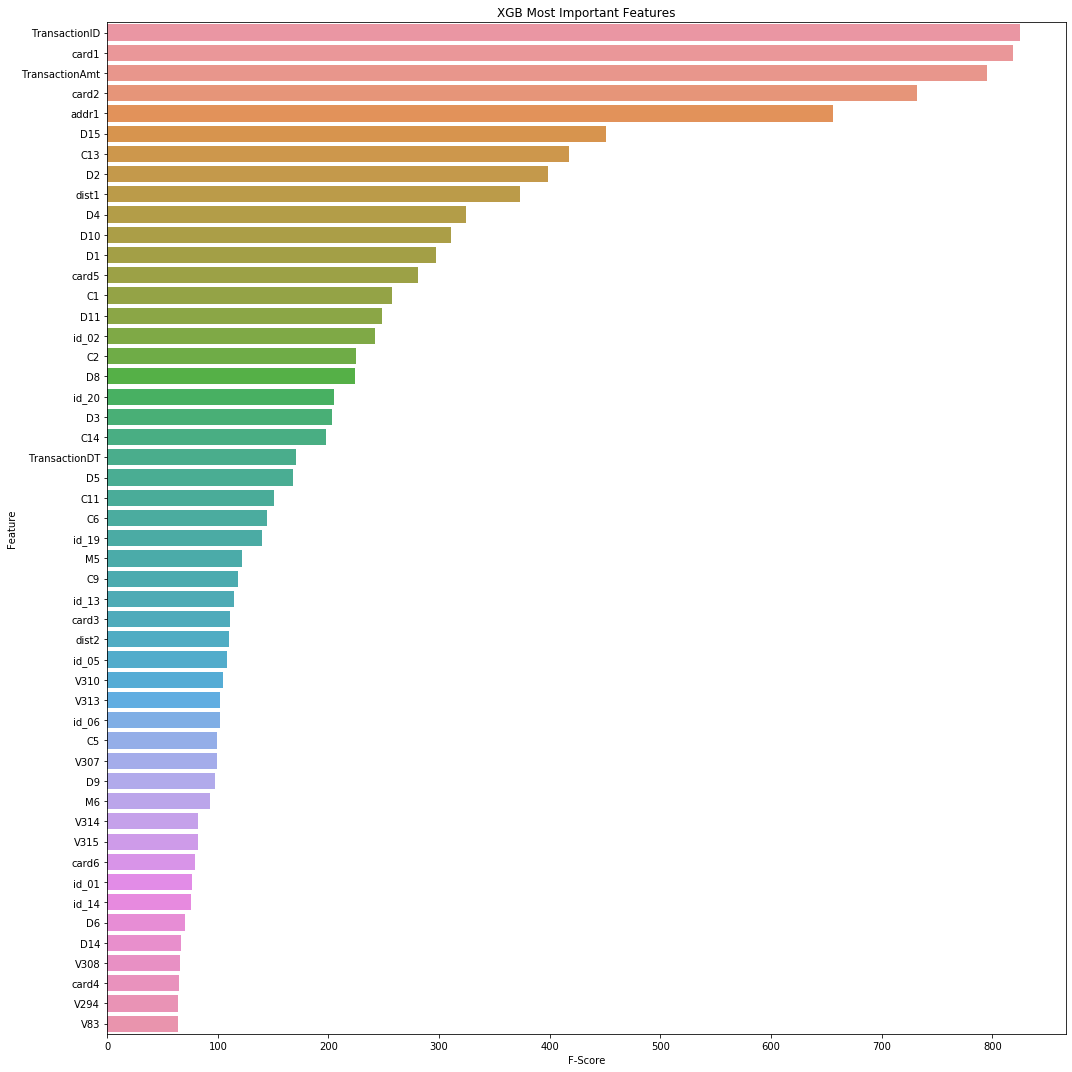

In [20]:
#feature_imp = pd.DataFrame(sorted(zip(featureDict.keys,featureDict.values)), columns=['Value','Feature'])
featureDict = XGModel.get_booster().get_fscore()
s = pd.DataFrame.from_dict(featureDict,orient='index').reset_index()
s.columns=['Feature','F-Score']
plt.figure(figsize=(15, 15))
sns.barplot(x='F-Score', y='Feature', data=s.sort_values(by='F-Score', ascending=False).iloc[:50])
plt.title('XGB Most Important Features')
plt.tight_layout()        

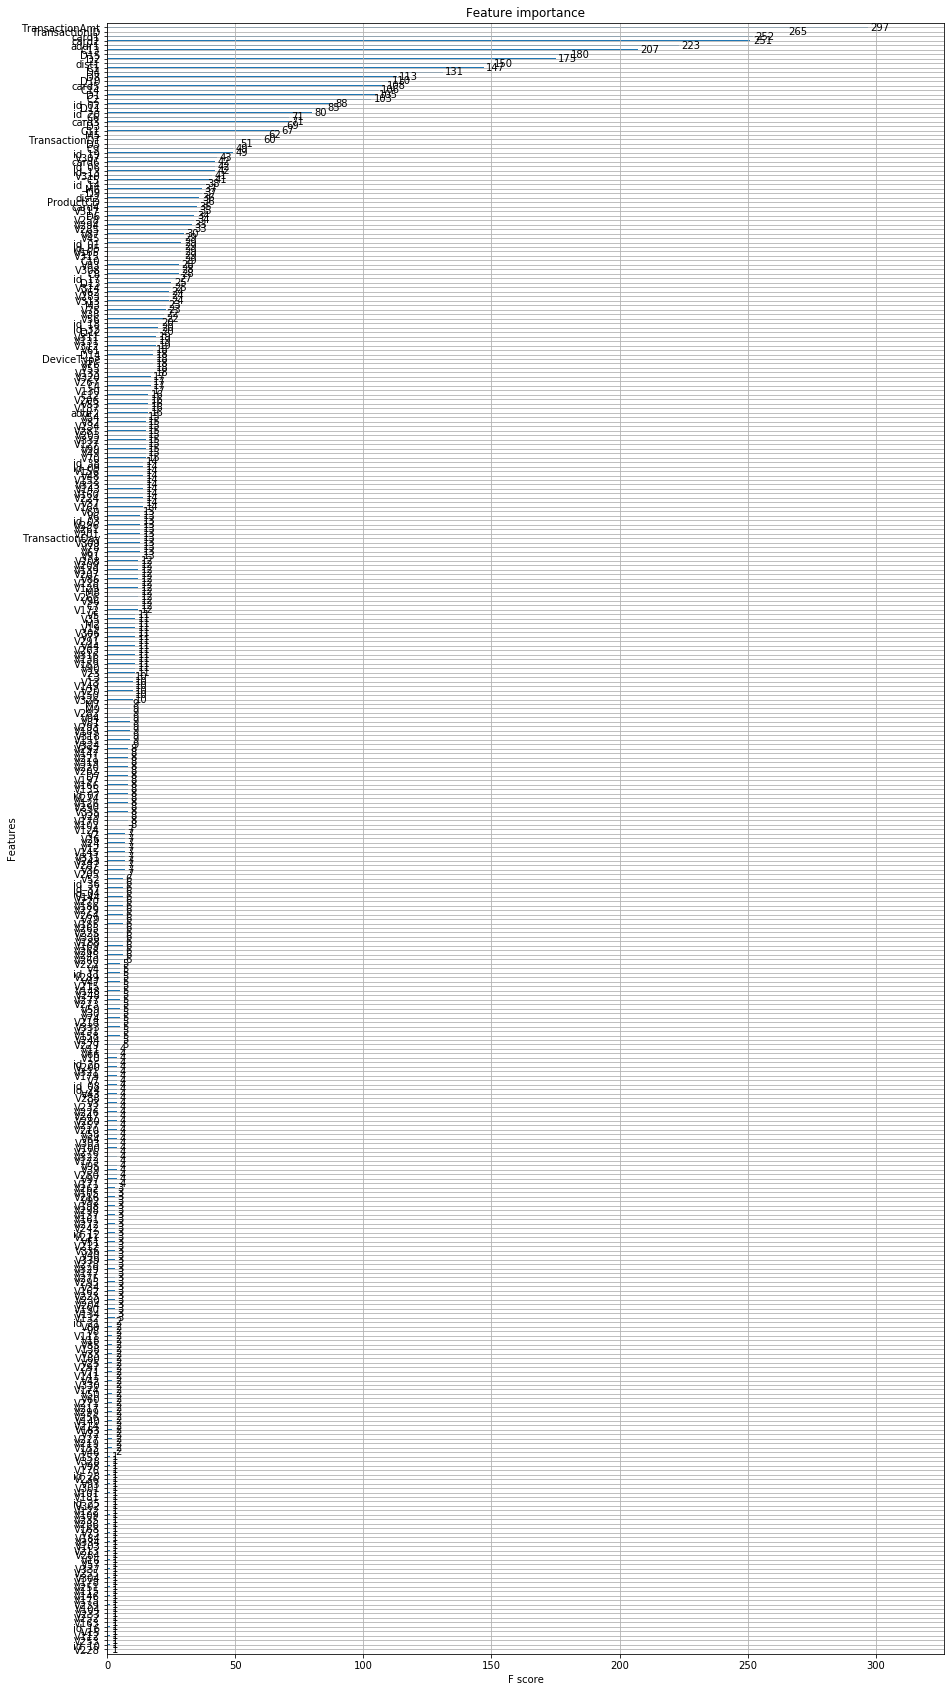

In [13]:
fig, ax = plt.subplots(figsize=(15, 30))
featureDict = XGModel.get_booster().get_fscore() #len(featureDict) = 363 
_ = plot_importance(XGModel, ax=ax) #total 421 features